### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [25]:
env = 'pc'  # 'pc', 'colab'
using_gpu = False

In [26]:
%%capture
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [27]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt




In [28]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [29]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (800, 2), Y: (800,)


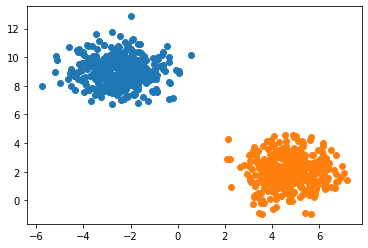

In [30]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)

def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

weights = calc_weight_matrix(X, weight_func = euclidian_similarity)


Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 400 instances of object 0.0
We have to delabel 388 instances
Found 400 instances of object 1.0
We have to delabel 388 instances

    We have 776 unlabeled data
    Out of 800
    


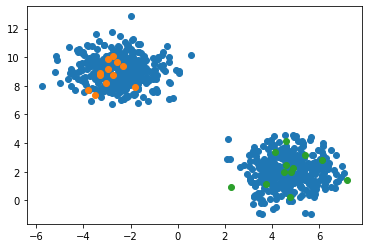

In [31]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [32]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [33]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [34]:
X.shape

(800, 2)

In [35]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 5, 
    delta_loss_limit = 0.008, 
    stop_loss = 19.6,
    weight_matrix = weights
)

Loss: 2386.9616490893322, delta loss: 2386.9616490893322
Loss: 2297.3105158759913, delta loss: 89.65113321334093
Loss: 2249.058788697388, delta loss: 48.25172717860323
Loss: 2217.529779201682, delta loss: 31.529009495706305
Loss: 2196.4153300722205, delta loss: 21.114449129461264




Accuracy: 1.0


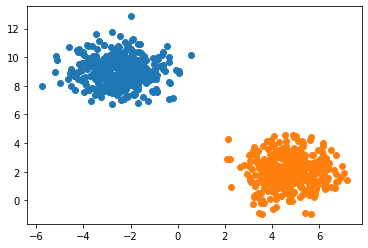

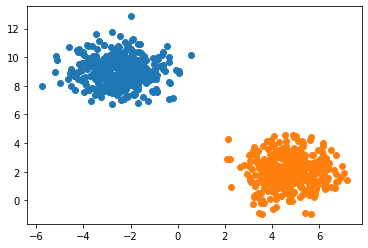

In [36]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

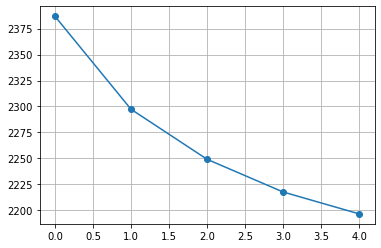

In [37]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [38]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [39]:
X.shape

(800, 2)

In [40]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 5, 
    delta_loss_limit = 0.008, 
    stop_loss = 19.6,
    weight_matrix = weights
)

Loss: 2386.9616490893322, Delta: 2386.9616490893322
Loss: 2273.291275786913, Delta: 113.6703733024192
Loss: 2220.0796524901434, Delta: 53.21162329676963
Loss: 2191.127361093176, Delta: 28.95229139696721
Loss: 2174.439955362402, Delta: 16.687405730774117


Accuracy: 1.0


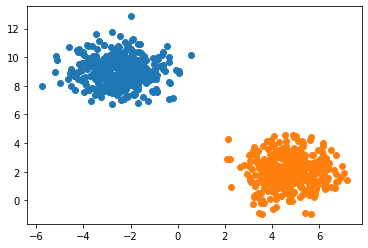

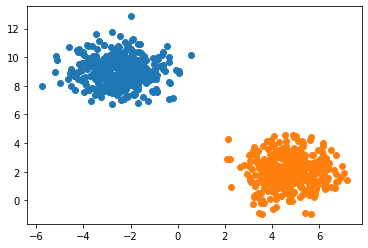

In [41]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

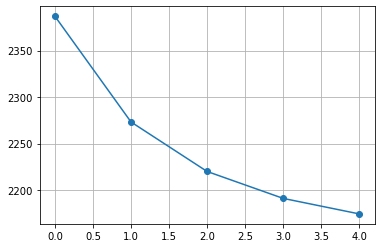

In [42]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [43]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00015,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [44]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 50,
    delta_loss_limit = 0.0,
    stop_loss = 19.7,
    weight_matrix = weights
)

Loss: 2386.9616490893322, Delta: 2386.9616490893322
Loss: 2386.9442843009674, Delta: 0.01736478836483002
Loss: 2386.9416192831777, Delta: 0.002665017789695412
Loss: 2386.923894694609, Delta: 0.017724588568853505
Loss: 2386.893190655945, Delta: 0.030704038663770916
Loss: 2386.8405133059873, Delta: 0.05267734995777573
Loss: 2386.829819931528, Delta: 0.010693374459151528
Loss: 2386.828606139933, Delta: 0.0012137915950916067
Loss: 2386.808145600032, Delta: 0.02046053990125074
Loss: 2386.8054663987637, Delta: 0.002679201268165343
Loss: 2386.7945114220624, Delta: 0.010954976701214036
Loss: 2386.789051717306, Delta: 0.005459704756503925
Loss: 2386.7850760829015, Delta: 0.0039756344044690195
Loss: 2386.7651110594124, Delta: 0.019965023489021405
Loss: 2386.7295084297502, Delta: 0.03560262966220762
Loss: 2386.7156537208875, Delta: 0.01385470886270923
Loss: 2386.697427781534, Delta: 0.018225939353669673
Loss: 2386.6934284829917, Delta: 0.0039992985421122285
Loss: 2386.689411836685, Delta: 0.00401

Accuracy: 0.5525


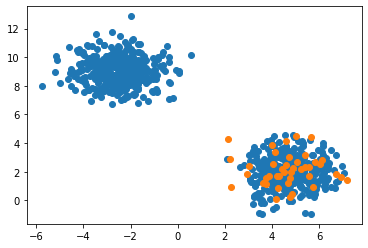

In [45]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

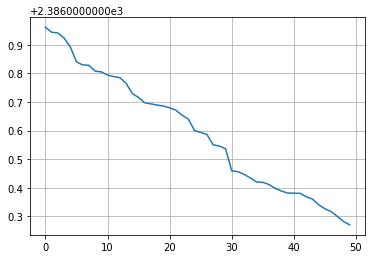

In [46]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [47]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [48]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 50, 
    delta_loss_limit = 0.0001,
    stop_loss = 19.8,
    weight_matrix = weights
)

Loss: 2386.9616490893322, Delta: 2386.9616490893322
Loss: 2273.9907631681463, Delta: 112.97088592118598
Loss: 2217.955434046889, Delta: 56.03532912125729
Loss: 2188.1231723579313, Delta: 29.832261688957715
Loss: 2171.8562202801445, Delta: 16.266952077786755
Loss: 2162.779477339858, Delta: 9.076742940286294
Loss: 2157.630672578797, Delta: 5.148804761061001
Loss: 2154.635151226057, Delta: 2.99552135274007
Loss: 2152.8362727899153, Delta: 1.7988784361418766
Loss: 2151.708150184597, Delta: 1.1281226053183673
Loss: 2150.9603675257317, Delta: 0.7477826588651624
Loss: 2150.432540170615, Delta: 0.5278273551166421
Loss: 2150.0351339046824, Delta: 0.39740626593265915
Loss: 2149.718054922109, Delta: 0.3170789825735483
Loss: 2149.4529492792126, Delta: 0.26510564289628746
Loss: 2149.2235337938687, Delta: 0.22941548534390677
Loss: 2149.020261954191, Delta: 0.2032718396776545
Loss: 2148.837348140589, Delta: 0.18291381360222658
Loss: 2148.6711328501106, Delta: 0.1662152904782488
Loss: 2148.51916878482

Accuracy: 0.99875


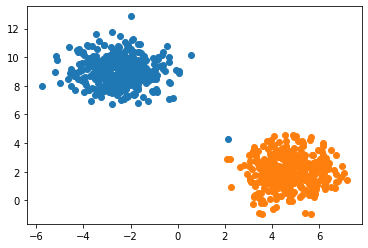

In [52]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

In [53]:
accuracy_score(Y, Y_preds_BCGD_cyclic)

0.99875

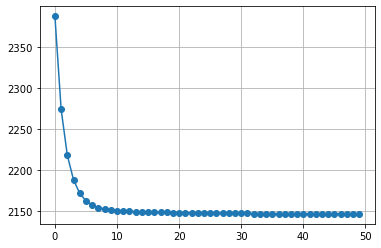

In [51]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [64]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [65]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [67]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [71]:
iters_limit = 100
delta_loss_limit = 0.0001
stop_loss = 19.7

if using_gpu:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()

    with tf.device(device_name):
        print(f'with GPU')
        preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )

else:
    print(f'without GPU')
    preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

without GPU
Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.3416952834

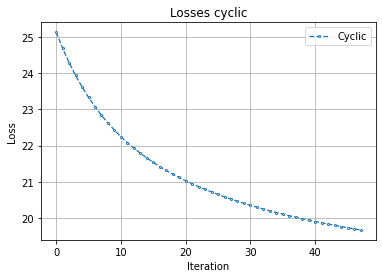

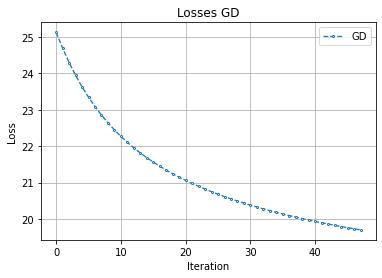

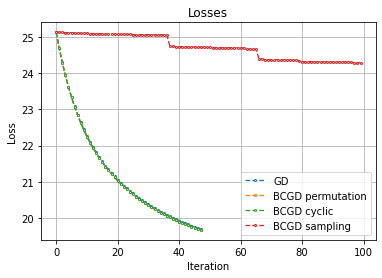

In [72]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots(figsize = (6, 4))

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(losses, 'Losses', y_label = 'Loss')

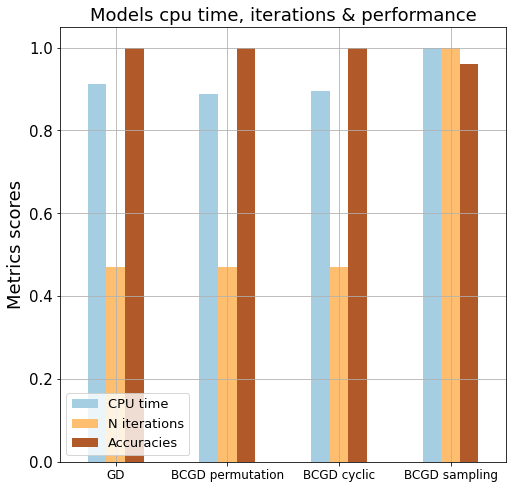

In [73]:
def plot_bar_metrics(metrics_df):
    
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired',
        figsize = (8, 8)
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

In [74]:
print(accuracies)
print(n_iters)
print(cpu_times)

{'GD': 1.0, 'BCGD permutation': 1.0, 'BCGD cyclic': 1.0, 'BCGD sampling': 0.96}
{'GD': 47, 'BCGD permutation': 47, 'BCGD cyclic': 47, 'BCGD sampling': 100}
{'GD': 1.6719717999999375, 'BCGD permutation': 1.6277214000000413, 'BCGD cyclic': 1.6390458000000763, 'BCGD sampling': 1.8320298000001003}


# Real dataset

In [23]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

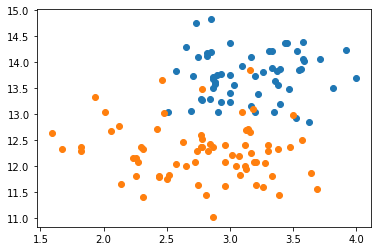

In [24]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [25]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = 0.06, # DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 55 instances
Found 71 instances of object 1.0
We have to delabel 66 instances


In [1]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

NameError: name 'plot_clusters' is not defined

In [2]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=50,
    delta_loss_limit = 0.003
)

NameError: name 'GradientDescentSolver' is not defined

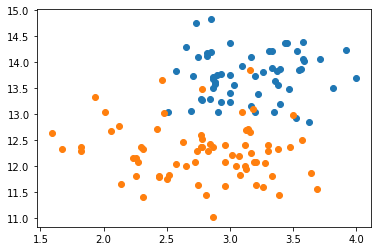

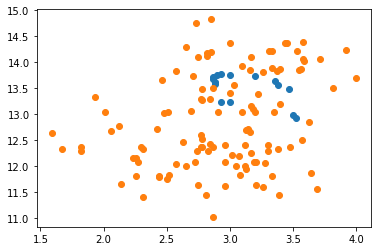

In [29]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)